In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from lstm_sine import SineData

In [2]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [3]:
if torch.cuda.is_available():
    device = "cuda:1"
else:
    print("Gpu not found")
    device = "cpu"

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, nodes=10, layers=1, memory=15, dropout=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=nodes, num_layers=layers, dropout=dropout
        )
        self.out = nn.Linear(nodes, 1)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        return self.out(h_n[-1])

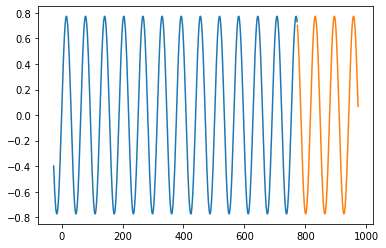

In [5]:
waves = 150
test = int(0.25 * waves)
f = 100
sample = 1000
future = 200
T = sample / f
if future >= sample:
    raise ValueError("Increase sample to be > future!")
# x =  torch.from_numpy(np.swapaxes( np.arange(0, sample) + np.zeros((waves, sample)),0,1)[:, :, np.newaxis]).float().to(device)
x = (
    torch.from_numpy(
        np.swapaxes(
            np.arange(0, sample) + np.random.randint(-4 * T, 4 * T, size=(waves, 1)),
            0,
            1,
        )[:, :, np.newaxis]
    )
    .float()
    .to(device)
)

print()


x_test = x[:, :test]
x = x[:, test:]

x_future = x[-future:]
x = x[:-future]
# with torch.no_grad():
random_amps = (
    torch.from_numpy(
        (10 ** (np.random.uniform(np.log10(0.1), np.log10(2), size=[waves, 1])))
    )
    .float()
    .to(device)
)
y_future = torch.sin(x_future / T) * random_amps[test:]
y = torch.sin(x / T) * random_amps[test:]
y_test = torch.sin(x_test / T) * random_amps[:test]
plt.plot(x.cpu().detach()[:, 0], y.cpu().detach()[:, 0])
plt.plot(x_future.cpu().detach()[:, 0], y_future.cpu().detach()[:, 0])
plt.show()

In [6]:
model = LSTMModel(nodes=51, layers=3, dropout=0).to(device)
model = torch.jit.script(model)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()
model.train()

for i in range(100):

    def closure():
        optimizer.zero_grad()
        # print(x)
        # exit()
        y_pred = model.forward(y[:-1])
        # print(y_pred.shape)
        # exit()
        loss = loss_func(y_pred, y[-1])
        print(f"Epoch {i}: {loss.item()}")
        loss.backward()
        return loss

    loss = closure()
    # optimizer.step()
    optimizer.step(closure)

Epoch 0: 0.39608654379844666
Epoch 0: 0.39608654379844666
Epoch 0: 0.3960197865962982
Epoch 0: 0.38605430722236633
Epoch 0: 0.3578522205352783
Epoch 0: 13.715470314025879
Epoch 0: 10.92679214477539
Epoch 0: 1.862728238105774
Epoch 0: 1.3518164157867432
Epoch 0: 1.1569609642028809
Epoch 0: 0.9721152782440186
Epoch 0: 0.8071329593658447
Epoch 0: 0.6655790209770203
Epoch 0: 0.5474573373794556
Epoch 0: 0.45184871554374695
Epoch 0: 0.37737029790878296
Epoch 0: 0.32136115431785583
Epoch 0: 0.27989906072616577
Epoch 0: 0.24901776015758514
Epoch 0: 0.2256091982126236
Epoch 0: 0.2075093388557434
Epoch 1: 0.19324928522109985
Epoch 1: 0.19324928522109985
Epoch 1: 0.18181589245796204
Epoch 1: 0.17249234020709991
Epoch 1: 0.16475923359394073
Epoch 1: 0.15823286771774292
Epoch 1: 0.15262475609779358
Epoch 1: 0.14771464467048645
Epoch 1: 0.1433316320180893
Epoch 1: 0.13934078812599182
Epoch 1: 0.13563348352909088
Epoch 1: 0.132120281457901
Epoch 1: 0.12872561812400818
Epoch 1: 0.12538383901119232
Epo

In [7]:
# sample_plot = 2
def pred(y, y_future, model=model):
    with torch.no_grad():
        batch = y.size(1)
        future = y_future.size(0)
        y_pred = torch.zeros(y.size(0) + future, batch, 1, device=device)
        y_pred[: y.size(0)] = y
        for i in range(future):
            y_pred[y.size(0) + i] = model.forward(y_pred[: y.size(0) + i])
        print(
            f"With {future} predicted points on a batch of {waves-test} we get a loss of {loss_func(y_pred[y.size(0):], y_future):.2e}"
        )
        y_pred = y_pred.cpu().detach()
        return y_pred

In [8]:
y_pred = pred(y, y_future)

With 200 predicted points on a batch of 113 we get a loss of 6.99e-04


In [35]:
def plot(x, x_future, y, y_future, y_pred, rows=2, plots=4, filename=None):
    plot_indices = np.random.choice(
        np.arange(y_pred.size(1)), size=[plots], replace=False
    )
    fig, ax = plt.subplots(
        plots // rows, rows, figsize=[10, 10], sharex=True, sharey=True
    )
    ax = ax.flatten()
    # print(len(ax), waves)
    for i, index in enumerate(plot_indices):
        ax[i].plot(x[:, index].cpu().detach(), y_pred[: y.size(0), index], color="blue")
        ax[i].plot(
            x_future[:, index].cpu().detach(),
            y_pred[y.size(0) :, index],
            color="yellow",
        )
        ax[i].plot(
            x_future[:, index].cpu().detach(),
            y_future[:, index].cpu().detach(),
            ":",
            color="black",
        )
    fig.legend(["Input", "Output", "True output"])
    fig.suptitle(f"{plots} randomly selected extrapolation plots.", size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    if filename:
        fig.savefig(filename, dpi=1000)
    plt.show()

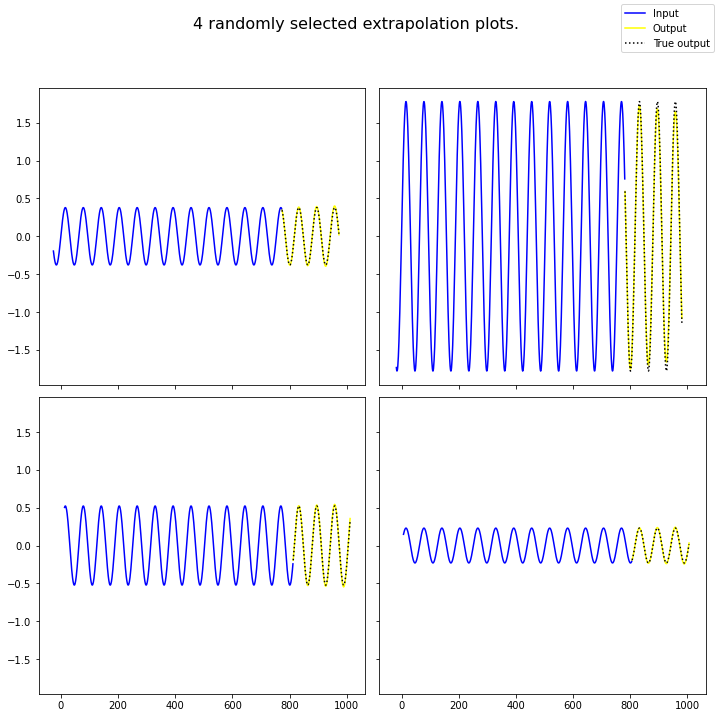

In [36]:
plot(x, x_future, y, y_future, y_pred, filename="train.pdf")

In [56]:
test_init = 999
y_pred_test = pred(y_test[:test_init], y_test[test_init:])

With 1 predicted points on a batch of 113 we get a loss of 2.62e-06


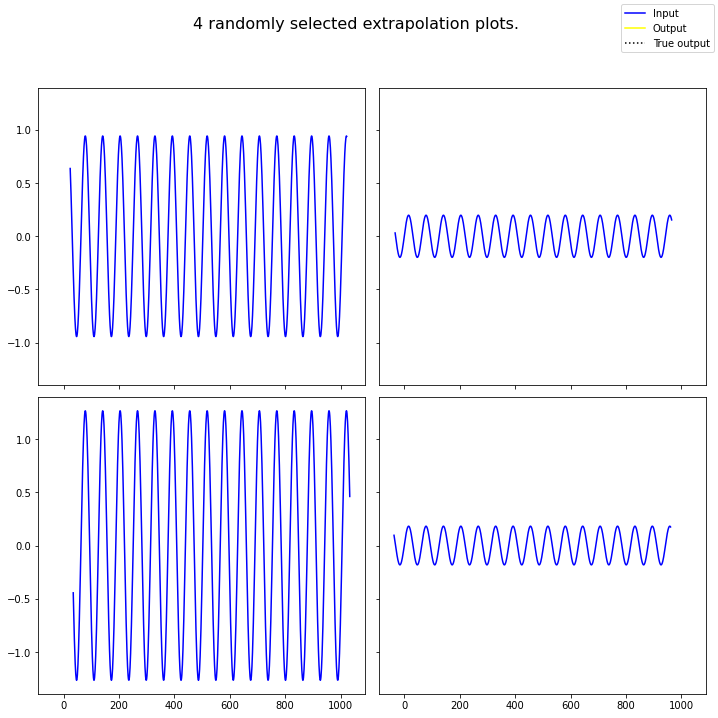

In [57]:
plot(
    x_test[:test_init],
    x_test[test_init:],
    y_test[:test_init],
    y_test[test_init:],
    y_pred_test,
    filename="test.pdf",
)